<a href="https://colab.research.google.com/github/choyoona/AI-IoT/blob/main/material/deep_learning/train_yolov3_raccoon_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv3 커스텀 데이터 학습

copy from https://articlearn.id/article/e5571bb0-how-to-train-yolov3-on-google-colab-to-de/

In [ ]:
# makesense.ai 레이블링 txt 만들기

# 임포트

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob


# Darknet 다운받아서 컴파일

## 프로젝트 다운로드

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 1 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.06 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (10362/10362), done.


OpenCV, GPU, CuDNN 사용 관련 설정하고 컴파일

In [ ]:
%cd darknet

/content/darknet


## 컴파일 설정 파일 수정

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

## 컴파일

In [ ]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

# 데이터 준비
- darknet/data/obj에 압축 풀기
- classes.names와 training.data 파일 생성
- training.txt 파일 생성


In [ ]:
!wget https://github.com/dhrim/cau_2022_summer/raw/master/material/deep_learning/data/Raccoon.zip

--2022-06-30 00:55:41--  https://github.com/dhrim/cau_2022_summer/raw/master/material/deep_learning/data/Raccoon.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/cau_2022_summer/master/material/deep_learning/data/Raccoon.zip [following]
--2022-06-30 00:55:41--  https://raw.githubusercontent.com/dhrim/cau_2022_summer/master/material/deep_learning/data/Raccoon.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5997816 (5.7M) [application/zip]
Saving to: ‘Raccoon.zip’

Raccoon.zip         100%[===================>]   5.72M  --.-KB/s    in 0.09s   

2022-06-30 00:55:41 (62.4 MB/s) - ‘Racco

## 압축 풀기

In [ ]:
!rm -rf data/obj
!mkdir data/obj
!unzip Raccoon.zip -d data/obj/Raccoon

Archive:  Raccoon.zip
   creating: data/obj/Raccoon/test/
  inflating: data/obj/Raccoon/test/_darknet.labels  
  inflating: data/obj/Raccoon/test/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg  
  inflating: data/obj/Raccoon/test/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.txt  
  inflating: data/obj/Raccoon/test/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.jpg  
  inflating: data/obj/Raccoon/test/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.txt  
  inflating: data/obj/Raccoon/test/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.jpg  
  inflating: data/obj/Raccoon/test/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.txt  
  inflating: data/obj/Raccoon/test/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.jpg  
  inflating: data/obj/Raccoon/test/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.txt  
  inflating: data/obj/Raccoon/test/raccoon-61_jpg.rf.58c4f561336525f59d395ce21508523b.jpg  
  inflating: data/obj/Raccoon/test/raccoon-61_jpg.rf.58c4f561

## 학습 위한 설정 파일 생성

### data/obj.names

In [7]:
%%writefile data/obj.names
Racoon

Writing data/obj.names


In [8]:
!cat data/obj.names

Racoon

In [9]:
!cp data/obj.names data/coco.names

### data/obj.data

In [10]:
%%writefile data/obj.data
classes = 1
train = data/train.txt
valid = data/test.txt
names = /content/darknet/data/obj.names
backup = ./

Writing data/obj.data


In [11]:
!cat data/obj.data

classes = 1
train = data/train.txt
valid = data/test.txt
names = /content/darknet/data/obj.names
backup = ./

### data/train.txt


In [13]:
!ls -al data/obj/Raccoon/Raccoon

total 652
drwxrwxr-x 2 root root  4096 Jul 26 01:17 .
drwxr-xr-x 4 root root  4096 Jul 26 01:31 ..
-rw-r--r-- 1 root root  6148 Jul 26 01:05 .DS_Store
-rw-rw-r-- 1 root root 34410 Jun  8  2021 raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg
-rw-rw-r-- 1 root root    37 Jul 25 16:15 raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.txt
-rw-rw-r-- 1 root root 25332 Jun  8  2021 raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.jpg
-rw-rw-r-- 1 root root    37 Jul 25 16:15 raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.txt
-rw-rw-r-- 1 root root 23652 Jun  8  2021 raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.jpg
-rw-rw-r-- 1 root root    37 Jul 25 16:15 raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.txt
-rw-rw-r-- 1 root root 24479 Jun  8  2021 raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.jpg
-rw-rw-r-- 1 root root    37 Jul 25 16:15 raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.txt
-rw-rw-r-- 1 root root 37719 Jun  8  2021 raccoon-61_jpg.rf.58c4f56133652

In [14]:
# ls -al data/obj/Raccoon 밑에 jpg 파일들이 있으면
# images_list = glob.glob("data/obj/laptops_labeled/*[jpg|png|jpeg]")
images_list = glob.glob("data/obj/Raccoon/Raccoon/*[jpg|png|jpeg]")

# ls -al data/obj 밑에 jpg 파일들이 있으면
# images_list = glob.glob("data/obj/*[jpg|png|jpeg]")

print(images_list)

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

['data/obj/Raccoon/Raccoon/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.jpg', 'data/obj/Raccoon/Raccoon/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.jpg', 'data/obj/Raccoon/Raccoon/raccoon-72_jpg.rf.8179b0a10f21dc1424a7ad48d8ef22f3.jpg', 'data/obj/Raccoon/Raccoon/raccoon-64_jpg.rf.5201bb870708d051100bbbb8c148ecd2.jpg', 'data/obj/Raccoon/Raccoon/raccoon-63_jpg.rf.1b33356e79739a8a1f3676a9f4f9f97a.jpg', 'data/obj/Raccoon/Raccoon/raccoon-71_jpg.rf.a66c60622f34ad56ff13e712485800ce.jpg', 'data/obj/Raccoon/Raccoon/raccoon-69_jpg.rf.87d4a574d6f7ab57f5fc39620df291f9.jpg', 'data/obj/Raccoon/Raccoon/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg', 'data/obj/Raccoon/Raccoon/raccoon-62_jpg.rf.e997ede5457f069436178f08065d9a61.jpg', 'data/obj/Raccoon/Raccoon/raccoon-6_jpg.rf.e1ef482779f9ef651ec62ed3a9c1e2d7.jpg', 'data/obj/Raccoon/Raccoon/raccoon-67_jpg.rf.626d83ff044dd4e2b37cbf4b4178eb89.jpg', 'data/obj/Raccoon/Raccoon/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.jpg', 'dat

In [15]:
!cat data/train.txt

data/obj/Raccoon/Raccoon/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.jpg
data/obj/Raccoon/Raccoon/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.jpg
data/obj/Raccoon/Raccoon/raccoon-72_jpg.rf.8179b0a10f21dc1424a7ad48d8ef22f3.jpg
data/obj/Raccoon/Raccoon/raccoon-64_jpg.rf.5201bb870708d051100bbbb8c148ecd2.jpg
data/obj/Raccoon/Raccoon/raccoon-63_jpg.rf.1b33356e79739a8a1f3676a9f4f9f97a.jpg
data/obj/Raccoon/Raccoon/raccoon-71_jpg.rf.a66c60622f34ad56ff13e712485800ce.jpg
data/obj/Raccoon/Raccoon/raccoon-69_jpg.rf.87d4a574d6f7ab57f5fc39620df291f9.jpg
data/obj/Raccoon/Raccoon/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg
data/obj/Raccoon/Raccoon/raccoon-62_jpg.rf.e997ede5457f069436178f08065d9a61.jpg
data/obj/Raccoon/Raccoon/raccoon-6_jpg.rf.e1ef482779f9ef651ec62ed3a9c1e2d7.jpg
data/obj/Raccoon/Raccoon/raccoon-67_jpg.rf.626d83ff044dd4e2b37cbf4b4178eb89.jpg
data/obj/Raccoon/Raccoon/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.jpg
data/obj/Raccoon/Raccoon/raccoon-70_jpg.r

# 4. 사전 학습된 YOLOv3 모델 파일 다운로드

In [16]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-07-26 01:40:11--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  55.8MB/s    in 2.8s    

2022-07-26 01:40:14 (55.8 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# 5. 학습관련 설정 파일 수정

원 설정파일 yolov3.cfg를 yolv3_custom.cfg로 복사하고

복사한 설정파일을 수정

In [17]:
# 탐지 대상 클래스 수를 설정
CLASS_NUM = 1

In [18]:
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

classes = CLASS_NUM
filters = (classes + 5) * 3
# max_batches = classes * 2000
max_batches = classes * 1000
steps1 = int(max_batches*0.8)
steps2 = int(max_batches*0.9)
# if max_batches < 6000:
#   max_batches = 6000      
# 실제로 할때는 위의 주석 두개 풀고 해야됨 5시간 넘게 걸려서 일부러 1000으로 한것
# 성능이 더 높아짐

# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/yolov3_custom.cfg
!sed -i '610 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '696 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '783 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '603 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '689 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '776 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i 's/steps=400000,450000/steps=$steps1,$steps2/' cfg/yolov3_custom.cfg

# 6. 학습 실행

학습된 모델은  ./yolov3_custom_last.weights 로 저장된다.

In [19]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show 
# !./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
 total_bbox = 66304, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.803088), count: 4, class_loss = 0.332866, iou_loss = 0.099293, total_loss = 0.432158 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000002, iou_loss = 0.000000, total_loss = 0.000002 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
 total_bbox = 66308, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.700868), count: 5, class_loss = 0.179714, iou_loss = 0.435444, total_loss = 0.615158 
v3 (mse loss, Normaliz

## 7. 탐지 실행

In [20]:
!./darknet detect cfg/yolov3_custom.cfg ./yolov3_custom_last.weights data/obj/Raccoon/Raccoon/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.59

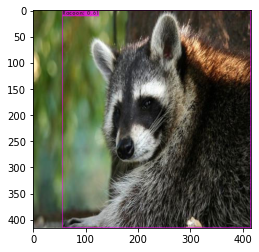

In [21]:
pred = plt.imread('predictions.jpg')
# plt.figure(figsize=(20,20))
plt.imshow(pred)
plt.show()